In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [14]:
# Define paths - UPDATE THESE TO YOUR ABCD DATA LOCATION
ABCD_DATA_PATH = "/Users/chloehampson/Desktop/hippo-amyg-depression/dset"  # UPDATE THIS PATH
OUTPUT_DIR = "/Users/chloehampson/Desktop/hippo-amyg-depression/derivatives"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /Users/chloehampson/Desktop/hippo-amyg-depression/derivatives


## 1. Load Data

Load the pre-prepared CSV files containing all necessary data.

In [15]:
# Load all data files
print("Loading data files...")

# Load demographics/covariates
demographics_df = pd.read_csv(os.path.join(ABCD_DATA_PATH, 'demographics.csv'))
print(f"Demographics loaded: {demographics_df.shape}")

# Load socioenvironmental data
socioenv_df = pd.read_csv(os.path.join(ABCD_DATA_PATH, 'socioenvironment.csv'))
print(f"Socioenvironmental loaded: {socioenv_df.shape}")

# Load depression data
depression_df = pd.read_csv(os.path.join(ABCD_DATA_PATH, 'depression.csv'))
print(f"Depression loaded: {depression_df.shape}")

# Load brain/task-FC data
brain_df = pd.read_csv(os.path.join(ABCD_DATA_PATH, 'task-FC.csv'))
print(f"Brain/task-FC loaded: {brain_df.shape}")

print("\nAll data files loaded successfully!")

Loading data files...
Demographics loaded: (68190, 9)
Socioenvironmental loaded: (68145, 17)
Depression loaded: (68042, 11)
Brain/task-FC loaded: (26329, 6)

All data files loaded successfully!


In [16]:
# Define sessions/timepoints to keep
SESSIONS_TO_KEEP = ['ses-00A', 'ses-04A']
SESSIONS_SOCIOENV = ['ses-00A', 'ses-03A', 'ses-04A']  # Include ses-03A for socioenvironmental
SESSIONS_DEPR = ['ses-04A']
SESSIONS_TASK = ['ses-04A']

print(f"Filtering to sessions: {SESSIONS_TO_KEEP}")
print(f"Socioenvironmental sessions: {SESSIONS_SOCIOENV}\n")

# Filter each dataframe
print(f"Demographics - Before: {len(demographics_df)} rows")
demographics_df = demographics_df[demographics_df['session_id'].isin(SESSIONS_TO_KEEP)]
print(f"Demographics - After: {len(demographics_df)} rows\n")

print(f"Socioenvironmental - Before: {len(socioenv_df)} rows")
socioenv_df = socioenv_df[socioenv_df['session_id'].isin(SESSIONS_SOCIOENV)]
print(f"Socioenvironmental - After: {len(socioenv_df)} rows\n")

print(f"Depression - Before: {len(depression_df)} rows")
depression_df = depression_df[depression_df['session_id'].isin(SESSIONS_DEPR)]
print(f"Depression - After: {len(depression_df)} rows\n")

print(f"Brain - Before: {len(brain_df)} rows")
brain_df = brain_df[brain_df['session_id'].isin(SESSIONS_TASK)]
print(f"Brain - After: {len(brain_df)} rows\n")

print("✓ All dataframes filtered to selected sessions")

Filtering to sessions: ['ses-00A', 'ses-04A']
Socioenvironmental sessions: ['ses-00A', 'ses-03A', 'ses-04A']

Demographics - Before: 68190 rows
Demographics - After: 21607 rows

Socioenvironmental - Before: 68145 rows
Socioenvironmental - After: 32037 rows

Depression - Before: 68042 rows
Depression - After: 9655 rows

Brain - Before: 26329 rows
Brain - After: 5696 rows

✓ All dataframes filtered to selected sessions


### 1.2 Backfill and Consolidate Socioenvironmental Data

### 1.1 Filter by Session/Timepoint

---

## 2. Define Variables

Define the variable lists for each analysis block.

In [17]:
# Covariate variables for residualization
COVARIATES = {
    'age': 'ab_p_demo_age',
    'sex': 'ab_g_stc__cohort_sex',
    'ethnicity': 'ab_g_stc__cohort_ethnrace__meim',
    'race': 'ab_g_stc__cohort_race__nih',
    'site': 'ab_g_dyn__design_site',
    'family_id': 'ab_g_stc__design_id__fam',
    #'mean_motion': 'mr_y_qc__mot__tfmri__nback__mot_mean'
}

print(f"Covariates defined: {len(COVARIATES)}")

Covariates defined: 6


In [18]:
# Family Environment
FAMILY_ENV_VARS = [
    'fc_p_fes__cohes_mean',      # Family cohesion
    'fc_p_fes__confl_mean',      # Family conflict
    'fc_p_fes__expr_mean',       # Family expression
    'fc_p_fes__intelcult_mean',  # Intellectual/cultural orientation
    'fc_p_fes__org_mean',        # Family organization
    'fc_p_fes__rec_mean',        # Active-recreational orientation
]

# Cultural & Social Environment
CULTURAL_SOCIAL_VARS = [
    #'fc_y_meim_mean',                          # MEIM Youth
    'fc_p_meim_mean',                          # MEIM Parent
    'le_l_nbhsoc__addr1__factor3_score',       # Neighborhood ethnic/immigrant
    'fc_y_srpf__env_mean',                     # School environment
]

# Socioeconomic Status
SES_VARS = [
    'le_l_nbhsoc__addr1__factor1_score',       # Neighborhood disadvantage
    'le_l_nbhsoc__addr1__aff_score',           # Neighborhood affluence
    'le_l_coi__addr1__coi__total__metro_score',# Child Opportunity Index
    'ab_p_demo__income__hhold_001',            # Household income
    'ab_g_dyn__cohort_edu__cgs',               # Caregiver education
]

# Combine all socioenvironmental variables
SOCIOENV_VARS = FAMILY_ENV_VARS + CULTURAL_SOCIAL_VARS + SES_VARS

print(f"Total SOCIOENVIRONMENTAL variables: {len(SOCIOENV_VARS)}")
print(f"  Family Environment: {len(FAMILY_ENV_VARS)}")
print(f"  Cultural/Social: {len(CULTURAL_SOCIAL_VARS)}")
print(f"  SES: {len(SES_VARS)}")

Total SOCIOENVIRONMENTAL variables: 14
  Family Environment: 6
  Cultural/Social: 3
  SES: 5


In [19]:
DEPRESSION_VARS = [
    # Summary scores
    'mh_p_cbcl__dsm__dep_sum',      # CBCL Depression (Parent)
    #'mh_y_ysr__dsm__dep_sum',       # YSR Depression (Youth)
    
    # Core symptoms - Parent report
    'mh_p_ksads__dep__mood__pres_sx',   # Depressed mood (Parent)
    'mh_p_ksads__dep__anhed__pres_sx',  # Anhedonia (Parent)
    #'mh_p_ksads__dep__fatig__pres_sx',  # Fatigue (Parent)
    
    # Core symptoms - Youth report
    'mh_y_ksads__dep__mood__pres_sx',   # Depressed mood (Youth)
    'mh_y_ksads__dep__anhed__pres_sx',  # Anhedonia (Youth)
    #'mh_y_ksads__dep__fatig__pres_sx',  # Fatigue (Youth)

# Additional CBCL Depression items - Parent report
    'mh_p_cbcl__anxdep__dep_001',
    'mh_p_cbcl__anxdep__dep_002',
    'mh_p_cbcl__anxdep__dep_003',
    'mh_p_cbcl__anxdep__dep_004'
]

print(f"Total DEPRESSION variables: {len(DEPRESSION_VARS)}")

Total DEPRESSION variables: 9


In [20]:
# Hippocampus ROIs
HIPPOCAMPUS_VARS = [
    'mr_y_tfmri__nback__2bv0b__aseg__hc__lh_beta',
    'mr_y_tfmri__nback__2bv0b__aseg__hc__rh_beta',  # Hippocampus Left and Right

]

# Amygdala ROIs
AMYGDALA_VARS = [
    'mr_y_tfmri__nback__emovntf__aseg__ag__lh_beta',
    'mr_y_tfmri__nback__emovntf__aseg__ag__rh_beta'
]

BRAIN_VARS = HIPPOCAMPUS_VARS + AMYGDALA_VARS

print(f"Total BRAIN variables: {len(BRAIN_VARS)}")
print(f"  Hippocampus: {len(HIPPOCAMPUS_VARS)}")
print(f"  Amygdala: {len(AMYGDALA_VARS)}")

Total BRAIN variables: 4
  Hippocampus: 2
  Amygdala: 2


---

## 3. Remove Missing Data

Going through each variable list and removing particpants with missing data.

In [21]:
# Subject identifier
SUBJECT_ID = 'participant_id'
SESSION_ID = 'session_id'

# Backfill socioenvironmental data across sessions for each participant
print("Backfilling socioenvironmental data across sessions...\n")

# Sort by participant and session to ensure proper filling order
socioenv_df = socioenv_df.sort_values([SUBJECT_ID, SESSION_ID])

# For each participant, backfill (use future values to fill earlier missing values) 
# and forward fill (use past values to fill later missing values)
print(f"Before backfill: {len(socioenv_df)} rows")
socioenv_df_filled = socioenv_df.groupby(SUBJECT_ID)[SOCIOENV_VARS].transform(
    lambda x: x.bfill().ffill()
)

# Replace the original variables with filled values
socioenv_df[SOCIOENV_VARS] = socioenv_df_filled

# Now consolidate to one row per participant (keep first occurrence after sorting)
print(f"Consolidating to one row per participant...")
socioenv_df = socioenv_df.drop_duplicates(subset=[SUBJECT_ID], keep='first')
print(f"After consolidation: {len(socioenv_df)} rows (unique participants)\n")

# Show session distribution before consolidation
print("✓ Socioenvironmental data backfilled and consolidated to one row per participant")

Backfilling socioenvironmental data across sessions...

Before backfill: 32037 rows
Consolidating to one row per participant...
After consolidation: 11868 rows (unique participants)

✓ Socioenvironmental data backfilled and consolidated to one row per participant


In [22]:
# Forward fill and consolidate demographics data
print("Forward filling demographics data across sessions...\n")
print("NOTE: Age variable will be taken from ses-04A only (not filled)\n")

# Sort by participant and session
demographics_df = demographics_df.sort_values([SUBJECT_ID, SESSION_ID])

# Separate age from other covariates
age_var = COVARIATES['age']
covariate_cols = [v for k, v in COVARIATES.items() if k != 'age']

# For each participant, forward fill non-age covariates
print(f"Before forward fill: {len(demographics_df)} rows")
demographics_df_filled = demographics_df.groupby(SUBJECT_ID)[covariate_cols].transform(
    lambda x: x.ffill()
)

# Replace the non-age covariate columns with filled values
demographics_df[covariate_cols] = demographics_df_filled

# For age, keep only ses-04A values by filtering to ses-04A before consolidation
# First, store ses-04A age values
age_ses04 = demographics_df[demographics_df[SESSION_ID] == 'ses-04A'][[SUBJECT_ID, age_var]]

# Consolidate to one row per participant (keep first occurrence after sorting)
print(f"Consolidating to one row per participant...")
demographics_df = demographics_df.drop_duplicates(subset=[SUBJECT_ID], keep='first')

# Merge in the ses-04A age values, replacing any existing age values
demographics_df = demographics_df.drop(columns=[age_var])
demographics_df = demographics_df.merge(age_ses04, on=SUBJECT_ID, how='left')

print(f"After consolidation: {len(demographics_df)} rows (unique participants)\n")

print("✓ Demographics data processed: covariates forward filled, age from ses-04A only")

Forward filling demographics data across sessions...

NOTE: Age variable will be taken from ses-04A only (not filled)

Before forward fill: 21607 rows
Consolidating to one row per participant...
After consolidation: 11868 rows (unique participants)

✓ Demographics data processed: covariates forward filled, age from ses-04A only


Calculating missing data percentages...



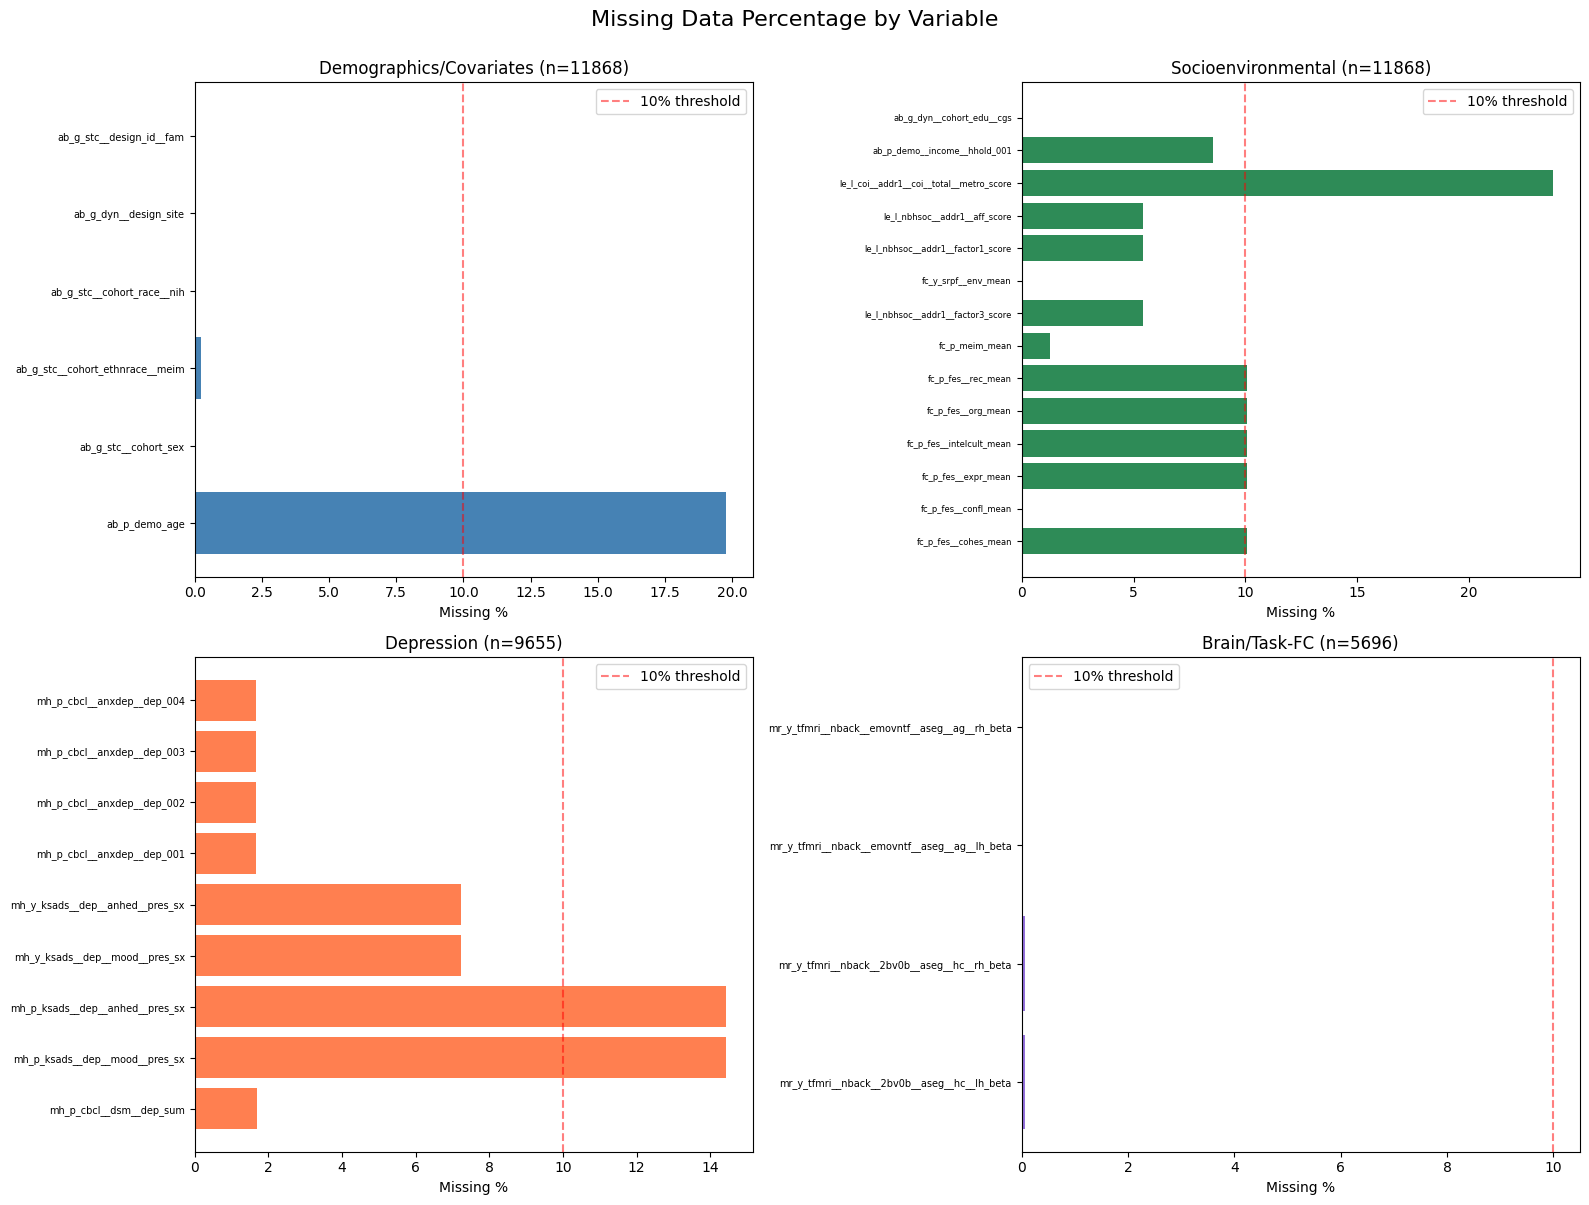


=== MISSING DATA SUMMARY ===

Demographics/Covariates:
  Mean missing: 3.34%
  Max missing: 19.78%

Socioenvironmental:
  Mean missing: 7.16%
  Max missing: 23.76%

Depression:
  Mean missing: 5.74%
  Max missing: 14.44%

Brain/Task-FC:
  Mean missing: 0.04%
  Max missing: 0.07%


In [23]:
import matplotlib.pyplot as plt

# Calculate missing data percentages for each variable set
def calc_missing_pct(df, var_list):
    """Calculate percentage of missing data for each variable"""
    missing_pct = {}
    for var in var_list:
        if var in df.columns:
            missing_pct[var] = (df[var].isna().sum() / len(df)) * 100
        else:
            missing_pct[var] = None  # Variable not found
    return missing_pct

# Calculate for all variable sets
print("Calculating missing data percentages...\n")

covariate_cols = list(COVARIATES.values())
demo_missing = calc_missing_pct(demographics_df, covariate_cols)
socioenv_missing = calc_missing_pct(socioenv_df, SOCIOENV_VARS)
depression_missing = calc_missing_pct(depression_df, DEPRESSION_VARS)
brain_missing = calc_missing_pct(brain_df, BRAIN_VARS)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Missing Data Percentage by Variable', fontsize=16, y=1.00)

# Demographics/Covariates
ax1 = axes[0, 0]
vars1 = [k for k, v in demo_missing.items() if v is not None]
pcts1 = [v for v in demo_missing.values() if v is not None]
ax1.barh(range(len(vars1)), pcts1, color='steelblue')
ax1.set_yticks(range(len(vars1)))
ax1.set_yticklabels(vars1, fontsize=7)
ax1.set_xlabel('Missing %')
ax1.set_title(f'Demographics/Covariates (n={len(demographics_df)})')
ax1.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax1.legend()

# Socioenvironmental
ax2 = axes[0, 1]
vars2 = [k for k, v in socioenv_missing.items() if v is not None]
pcts2 = [v for v in socioenv_missing.values() if v is not None]
ax2.barh(range(len(vars2)), pcts2, color='seagreen')
ax2.set_yticks(range(len(vars2)))
ax2.set_yticklabels(vars2, fontsize=6)
ax2.set_xlabel('Missing %')
ax2.set_title(f'Socioenvironmental (n={len(socioenv_df)})')
ax2.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax2.legend()

# Depression
ax3 = axes[1, 0]
vars3 = [k for k, v in depression_missing.items() if v is not None]
pcts3 = [v for v in depression_missing.values() if v is not None]
ax3.barh(range(len(vars3)), pcts3, color='coral')
ax3.set_yticks(range(len(vars3)))
ax3.set_yticklabels(vars3, fontsize=7)
ax3.set_xlabel('Missing %')
ax3.set_title(f'Depression (n={len(depression_df)})')
ax3.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax3.legend()

# Brain
ax4 = axes[1, 1]
vars4 = [k for k, v in brain_missing.items() if v is not None]
pcts4 = [v for v in brain_missing.values() if v is not None]
ax4.barh(range(len(vars4)), pcts4, color='mediumpurple')
ax4.set_yticks(range(len(vars4)))
ax4.set_yticklabels(vars4, fontsize=7)
ax4.set_xlabel('Missing %')
ax4.set_title(f'Brain/Task-FC (n={len(brain_df)})')
ax4.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10% threshold')
ax4.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== MISSING DATA SUMMARY ===")
print(f"\nDemographics/Covariates:")
print(f"  Mean missing: {np.mean(pcts1):.2f}%")
print(f"  Max missing: {np.max(pcts1):.2f}%")

print(f"\nSocioenvironmental:")
print(f"  Mean missing: {np.mean(pcts2):.2f}%")
print(f"  Max missing: {np.max(pcts2):.2f}%")

print(f"\nDepression:")
print(f"  Mean missing: {np.mean(pcts3):.2f}%")
print(f"  Max missing: {np.max(pcts3):.2f}%")

print(f"\nBrain/Task-FC:")
print(f"  Mean missing: {np.mean(pcts4):.2f}%")
print(f"  Max missing: {np.max(pcts4):.2f}%")

In [24]:
# Remove rows with missing data for each dataframe
print("Removing rows with missing data...\n")

# Demographics/Covariates
print(f"Demographics - Before: {len(demographics_df)} rows")
covariate_cols = list(COVARIATES.values())
demographics_clean = demographics_df.dropna(subset=covariate_cols)
print(f"Demographics - After: {len(demographics_clean)} rows ({len(demographics_df) - len(demographics_clean)} removed)\n")

# Socioenvironmental
print(f"Socioenvironmental - Before: {len(socioenv_df)} rows")
socioenv_clean = socioenv_df.dropna(subset=SOCIOENV_VARS)
print(f"Socioenvironmental - After: {len(socioenv_clean)} rows ({len(socioenv_df) - len(socioenv_clean)} removed)\n")

# Depression
print(f"Depression - Before: {len(depression_df)} rows")
depression_clean = depression_df.dropna(subset=DEPRESSION_VARS)
print(f"Depression - After: {len(depression_clean)} rows ({len(depression_df) - len(depression_clean)} removed)\n")

# Brain/task-FC
print(f"Brain - Before: {len(brain_df)} rows")
brain_clean = brain_df.dropna(subset=BRAIN_VARS)
print(f"Brain - After: {len(brain_clean)} rows ({len(brain_df) - len(brain_clean)} removed)\n")

# Update the original dataframes
demographics_df = demographics_clean
socioenv_df = socioenv_clean
depression_df = depression_clean
brain_df = brain_clean

print("✓ Missing data removed from all dataframes")

Removing rows with missing data...

Demographics - Before: 11868 rows
Demographics - After: 9518 rows (2350 removed)

Socioenvironmental - Before: 11868 rows
Socioenvironmental - After: 7510 rows (4358 removed)

Depression - Before: 9655 rows
Depression - After: 7811 rows (1844 removed)

Brain - Before: 5696 rows
Brain - After: 5692 rows (4 removed)

✓ Missing data removed from all dataframes


---

## 3. Filter Subjects

Figuring out what time point gives us the most useful data.

In [25]:
# Find participants that appear in all 4 dataframes
print("Finding common participants across all dataframes...\n")

# Get unique participant IDs from each dataframe
demo_ids = set(demographics_df[SUBJECT_ID].unique())
socioenv_ids = set(socioenv_df[SUBJECT_ID].unique())
depression_ids = set(depression_df[SUBJECT_ID].unique())
brain_ids = set(brain_df[SUBJECT_ID].unique())

print(f"Demographics: {len(demo_ids)} unique participants")
print(f"Socioenvironmental: {len(socioenv_ids)} unique participants")
print(f"Depression: {len(depression_ids)} unique participants")
print(f"Brain: {len(brain_ids)} unique participants\n")

# Find intersection (participants present in ALL dataframes)
common_ids = demo_ids & socioenv_ids & depression_ids & brain_ids
print(f"Common participants across all 4 dataframes: {len(common_ids)}\n")

# Filter each dataframe to only include common participants
print("Filtering dataframes to common participants...")
demographics_df = demographics_df[demographics_df[SUBJECT_ID].isin(common_ids)]
socioenv_df = socioenv_df[socioenv_df[SUBJECT_ID].isin(common_ids)]
depression_df = depression_df[depression_df[SUBJECT_ID].isin(common_ids)]
brain_df = brain_df[brain_df[SUBJECT_ID].isin(common_ids)]

print(f"Demographics filtered: {len(demographics_df)} rows")
print(f"Socioenvironmental filtered: {len(socioenv_df)} rows")
print(f"Depression filtered: {len(depression_df)} rows")
print(f"Brain filtered: {len(brain_df)} rows")
print("\n✓ All dataframes filtered to common participants")

Finding common participants across all dataframes...

Demographics: 9518 unique participants
Socioenvironmental: 7510 unique participants
Depression: 7811 unique participants
Brain: 5692 unique participants

Common participants across all 4 dataframes: 3405

Filtering dataframes to common participants...
Demographics filtered: 3405 rows
Socioenvironmental filtered: 3405 rows
Depression filtered: 3405 rows
Brain filtered: 3405 rows

✓ All dataframes filtered to common participants


In [ ]:
# Save cleaned dataframes to derivatives folder
print("Saving cleaned dataframes to derivatives folder...\n")
print("Keeping only specified columns for each dataframe, excluding participant_id\n")

✓ Saved: demographics_clean.csv ({len(demographics_df)} rows, {len(demo_cols)} columns)")
✓ Saved: demographics_clean.csv ({len(demographics_df)} rows, {len(demo_cols)} columns)")

# Socioenvironmental: Keep only socioenvironmental variables (exclude participant_id)
socioenv_cols = SOCIOENV_VARS
socioenv_df[socioenv_cols].to_csv(os.path.join(OUTPUT_DIR, 'socioenvironment_clean.csv'), index=False)
print(f"✓ Saved: socioenvironment_clean.csv ({len(socioenv_df)} rows, {len(socioenv_cols)} columns)")

# Depression: Keep only depression variables (exclude participant_id)
depression_cols = DEPRESSION_VARS
depression_df[depression_cols].to_csv(os.path.join(OUTPUT_DIR, 'depression_clean.csv'), index=False)
print(f"✓ Saved: depression_clean.csv ({len(depression_df)} rows, {len(depression_cols)} columns)")

# Brain: Keep only brain variables (exclude participant_id)
brain_cols = BRAIN_VARS
brain_df[brain_cols].to_csv(os.path.join(OUTPUT_DIR, 'task-FC_clean.csv'), index=False)
print(f"✓ Saved: task-FC_clean.csv ({len(brain_df)} rows, {len(brain_cols)} columns)")

print(f"\n✓ All cleaned dataframes saved to: {OUTPUT_DIR}")

Saving cleaned dataframes to derivatives folder...

Keeping only specified columns for each dataframe, excluding participant_id

✓ Saved: demographics_clean.csv (3405 rows, 6 columns)
✓ Saved: socioenvironment_clean.csv (3405 rows, 14 columns)
✓ Saved: depression_clean.csv (3405 rows, 9 columns)
✓ Saved: task-FC_clean.csv (3405 rows, 4 columns)

✓ All cleaned dataframes saved to: /Users/chloehampson/Desktop/hippo-amyg-depression/derivatives
